In [1]:
import scipy.sparse as sparse
from scipy.sparse import csr_matrix

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm.data import Dataset
from sklearn.metrics import roc_auc_score
import pandas_profiling

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Any results you write to the current directory are saved as output.
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data loading and overview


In [3]:
train = pd.read_csv('recommendationsv4/train.csv')
test = pd.read_csv('recommendationsv4/test.csv')
submission = pd.read_csv('recommendationsv4/sample_submission.csv')

try:
    food_dict = pd.read_csv('food_table.csv', index_col=[0])
except:
    food_dict = pd.read_json('recommendationsv4/meta_Grocery_and_Gourmet_Food.json', lines=True)
    food_dict.to_csv('food_table.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# EDA

In [4]:
# Посмотрим на датасет: это сведения об отзывах, которые сделали пользователи по товарам
print('train.shape = ', train.shape)
train.head(5)

train.shape =  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [5]:
# Посмотрим на типы данных и количество пропущенных значений
display(train.info())
display(train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


None

overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         176
reviewText           279
summary              170
unixReviewTime         0
vote              739155
style             413489
image             850753
userid                 0
itemid                 0
rating                 0
dtype: int64

In [6]:
train[train.reviewerName.isna()].sample(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
273305,5.0,True,"03 20, 2018",B0001LO3FG,NaN,Love this tea!,Five Stars,1521504000,NaN,"{'Size:': ' 20 Count (Pack of 6)', 'Flavor:': ...",NaN,10625,379,1.0
17130,5.0,True,"02 6, 2012",B0014EUAEW,NaN,"Low calorie, low carb, adds flavor to everythi...",YUM,1328486400,NaN,"{'Size:': ' 48 Ounce (Pack of 8)', 'Flavor:': ...",NaN,88531,6131,1.0
351281,5.0,True,"11 13, 2016",B0024SASYY,NaN,"Best tea ever, they sell it in parnea bread s...",Best tea ever,1478995200,NaN,"{'Size:': ' 50 Tea Bag Tin', 'Flavor:': ' Hone...",NaN,37516,10036,1.0


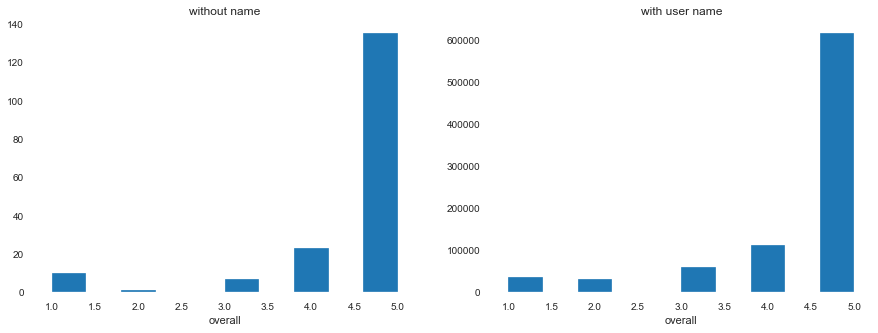

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('without name')
axes[0].set_xlabel('overall')
axes[1].set_xlabel('overall')
axes[1].set_title('with user name')
axes[0].hist(train[train.reviewerName.isna() == True].overall)
axes[1].hist(train[train.reviewerName.isna() == False].overall)
plt.show()

Есть немного пропусков в поле *reviewerName*. Это никак не влияет на остальные данные, тк данные с пропущенными *reviewerName* выглядят нормально, поэтому просто удалим этот столбец и будем идентифицировать пользователья только по *userid*. Дополнительно убедимся в этом, посмотрев на распределениe первоначальной оценки *overall* для клиентов с наличием *reviewerName* и его отсутствием.

Также есть пропуски в столбцах:
*vote* - количество проголосовавших за отзыв, удалим,
*style* - характеристики товара, *image* - пропусков очень много,удалим

In [8]:
train.drop(['image', 'reviewerName'], axis=1, inplace=True)
train.head(3)

,overall,verified,reviewTime,asin,reviewText,summary,unixReviewTime,vote,style,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,39495,5600,1.0


In [9]:
# Посмотрим на количество дубликатов
train.duplicated().value_counts()

False    828935
True      28960
dtype: int64

In [10]:
train.drop_duplicates(inplace=True)

In [11]:
print(train.shape)
train.head()

(828935, 12)


,overall,verified,reviewTime,asin,reviewText,summary,unixReviewTime,vote,style,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},74859,4349,1.0


Посмотрим на целевую переменную, пользователей, продукты:

In [12]:
def review(df):
    # Посмотрим на целевую переменную, пользователей, продукты:
    print('Число уникальных пользователей:', df['userid'].nunique())
    print('Число уникальных товаров:', df['itemid'].nunique())
    # Оценим пропорцию классов в целевой переменной
    sns.countplot(df['rating']).set_title("Пропорция классов в целевой переменной")
    
    # Посмотрим на наиболее популярные продукты
    popular_products = pd.DataFrame(df.groupby('itemid')['rating'].count())
    most_popular = popular_products.sort_values('rating', ascending=False)
    ax = most_popular.head(30).plot(kind = "bar")
    ax.set_title('Наиболее популярные продукты')
    
    # Посмотрим на пользователей, который выставляли больше всего оценок
    users = pd.DataFrame(df.groupby('userid')['rating'].count())
    active_users = users.head(30).sort_values('rating', ascending=False)
    ax = active_users.head(30).plot(kind = "bar")
    ax.set_title('Активные пользователи')

Число уникальных пользователей: 127448
Число уникальных товаров: 41302


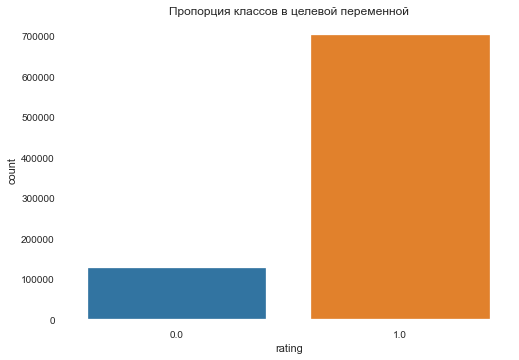

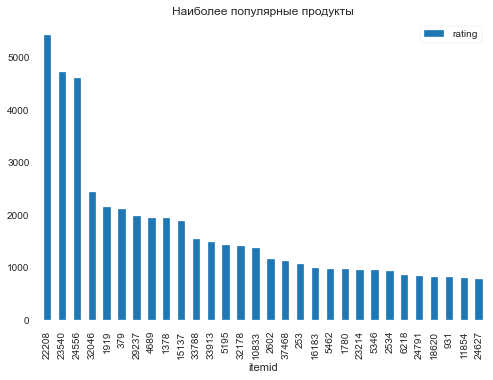

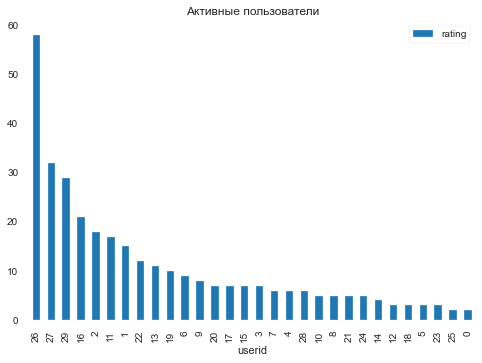

In [13]:
review(train)

Посмотрим на тестовые данные

In [14]:
profil = pandas_profiling.ProfileReport(test, minimal=True)

In [68]:
profil

Так же много пропусков в *vote*

In [16]:
test.drop(['image', 'reviewerName'], axis=1, inplace=True)

In [17]:
test.head()

,verified,reviewTime,asin,unixReviewTime,vote,style,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,1475280000,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,1404000000,2,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,1431993600,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,1412467200,NaN,{'Flavor:': ' Sweet Rose'},26206,11957,3
4,True,"11 11, 2013",B003XUJ564,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",59366,12173,4


Посмотрим на мета-словарь для продуктов:

In [18]:
display(food_dict.info())
food_dict.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275766 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 39.4+ MB


None

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eg...","['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'S...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B0...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking',...","['Shipped from UK, please allow 10 to 21 busin...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,NaN,NaN,NaN,NaN,NaN,NaN
2,"['Grocery & Gourmet Food', 'Cooking & Baking',...",['Jazz up your cakes with a sparkling monogram...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",['B07DXN65TF'],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"['Grocery & Gourmet Food', 'Cooking & Baking',...","['Large Letter - Height 4.75""']",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","['Large Letter - Height 4.75""']",NaN,NaN,NaN,NaN
4,"['Grocery & Gourmet Food', 'Cooking & Baking',...","['4.75""']",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","['4.75"" height']",NaN,NaN,NaN,NaN


In [69]:
food_prof = pandas_profiling.ProfileReport(food_dict, minimal=True)
food_prof

Много столбцов с пропусками или сложной структурой, пока возьмем: *asin*, *main_cat*,*brand*, *price*

In [20]:
food = food_dict[['asin', 'category', 'main_cat','brand', 'price']]

In [21]:
# Посмотрим на количество дубликатов
food.duplicated().value_counts()

False    283512
True       3697
dtype: int64

In [22]:
food['price'][food['price'].str.find(',')>0]

42672              $1,257.00
55266              $1,742.66
55289              $2,460.40
55513              $1,089.00
66246              $2,716.30
83248              $1,156.61
90436              $2,491.39
92503              $2,999.00
137044             $5,600.00
147230    $75.00 - $1,602.50
207708             $1,004.52
282620             $1,061.00
Name: price, dtype: object

In [23]:
food['price'][food['price'].str.find('-')>0]

12564      $9.97 - $137.08
20860      $10.00 - $81.99
21353     $12.47 - $109.99
29903      $19.49 - $36.50
33543      $20.08 - $43.41
                ...       
279638      $8.98 - $33.25
280807    $24.99 - $172.31
281493      $4.87 - $12.95
282250    $17.15 - $160.00
285559    $11.88 - $177.28
Name: price, Length: 100, dtype: object

In [24]:
food.drop_duplicates(keep='first', inplace=True)

food['category'].fillna('NaN', inplace=True)
food['main_cat'].fillna('NaN', inplace=True)
food['brand'].fillna('NaN', inplace=True)
# food['price'].fillna('NaN', inplace=True)
food['price'] = food['price'].replace('\$','',regex=True)
food['price'] = food['price'].replace('\,','',regex=True)
food['price_min'] = food['price'].str.partition('-')[0].astype(float)
food['price_max'] = food['price'].str.partition('-')[0].astype(float)
food['brand'].fillna('NaN', inplace=True)
food['price_diff'] = food['price_max'] - food['price_min']



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Stas\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [25]:
# Посмотрим на средние цены по категориям
food.groupby('main_cat').mean()

,price_min,price_max,price_diff
main_cat,,,
All Beauty,21.746172,21.746172,0.0
All Electronics,116.816000,116.816000,0.0
Amazon Home,16.042926,16.042926,0.0
Appliances,NaN,NaN,NaN
"Arts, Crafts & Sewing",16.619577,16.619577,0.0
Automotive,17.380000,17.380000,0.0
Baby,20.846852,20.846852,0.0
Camera & Photo,4.110000,4.110000,0.0
Car Electronics,NaN,NaN,NaN


Так как не по всем категориям есть цены, заполним пропуски просто средней ценой

In [26]:
food['price_max'].mean()

25.485856919112695

In [27]:
food['price_min'].fillna(food['price_min'].mean(), inplace=True)
food['price_max'].fillna(food['price_max'].mean(), inplace=True)
food.drop(['price', 'price_diff'], axis=1, inplace=True)

C:\Users\Stas\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\Stas\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
submission

,Id,rating
0,0,0.282813
1,1,0.629758
2,2,0.916899
3,3,0.702790
4,4,0.043446
...,...,...
285960,285960,0.049774
285961,285961,0.235110
285962,285962,0.525945
285963,285963,0.259647


# Feature Engineering

In [29]:
#  Импортируем энкодер для дальнейшей работы с кат.фичами
from sklearn.preprocessing import LabelEncoder
from category_encoders import CatBoostEncoder



labelencoder = LabelEncoder()
catboostencoder = CatBoostEncoder()

In [30]:
# Определим функцию для предобработки тренировочных и тестовых данных

def data_preparation(df):
    
    # Добавляю по ключу asin в выборку доп.поля из мета-словаря
    df = pd.merge(df, food, how='left', on='asin')
   
    # Обрабатываю поля с датами
    df['reviewTime'] = pd.to_datetime(df['reviewTime'])
    df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
    
    # Готовим в трейне поле для формирования матрицы sample_weights, в тесте его использовать не будем
    oldest_review = df['reviewTime'].min()
    df['weights'] = (df['reviewTime'] - oldest_review).dt.days + 1
   
    # Добавляю поле с числом дней
    df['DaysPassed'] = (pd.datetime.now() - df['unixReviewTime']).dt.days
    
    # Добавляю поля с числом пользователей и продуктов
    df['num_of_items_per_user'] = df.groupby(['userid'])['itemid'].transform('count')
    df['num_of_users_per_item'] = df.groupby(['itemid'])['userid'].transform('count')

    # Конвертирую verified в int
    df['verified']=df['verified'].astype('int64')


    for feature in ['brand','main_cat', 'category']:
        df[feature] = labelencoder.fit_transform(df[feature]) 

    df.vote=df['vote'].replace('\,','',regex=True).astype(float)
    df.vote=df['vote'].replace('\'','',regex=True).astype(float)
    df['vote'].fillna(0,inplace=True)

#     df['price']=df['price'].replace('\$','',regex=True)
#     df['price']= catboostencoder.fit_transform(df['price'], df['overall']) 

    df['ft1'] = df['unixReviewTime'].dt.weekday+df['verified']
    df['ft2'] = df['unixReviewTime'].dt.weekday*df['DaysPassed']
    
    for feature in ['vote','ft1','ft2','main_cat','brand','price_min', 'price_max',
                    'num_of_items_per_user','num_of_users_per_item',
                    'DaysPassed','weights', 'category']:
        df[feature]=(df[feature] - df[feature].min())/(df[feature] - df[feature].min()).max()
    
    return df

In [31]:
train = data_preparation(train)
train = train[['userid', 'itemid','vote', 'category', 'main_cat', 'brand', 'price_min', 'price_max',
               'DaysPassed', 'num_of_items_per_user', 'num_of_users_per_item',
               'ft1','ft2','weights','rating']]
train.to_csv('train_working.csv')
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,userid,itemid,vote,category,main_cat,brand,price_min,price_max,DaysPassed,num_of_items_per_user,num_of_users_per_item,ft1,ft2,weights,rating
0,102179,37138,0.00000,0.545208,0.352941,0.699413,0.009950,0.009950,0.109837,0.011905,0.001289,0.285714,0.038579,0.890163,1.0
1,3625,17322,0.00000,0.032550,0.352941,0.846267,0.018499,0.018499,0.142577,0.102381,0.012157,0.285714,0.044521,0.857423,1.0
2,39495,5600,0.01722,0.007233,0.352941,0.894203,0.025502,0.025502,0.124925,0.028571,0.125622,1.000000,0.247905,0.875075,1.0
3,72854,30249,0.00000,0.588608,0.352941,0.308707,0.044985,0.044985,0.279572,0.016667,0.041076,0.571429,0.208149,0.720428,1.0
4,74859,4349,0.00000,0.909584,0.352941,0.567900,0.025502,0.025502,0.112855,0.009524,0.005894,0.428571,0.078254,0.887145,1.0


<AxesSubplot:xlabel='brand'>

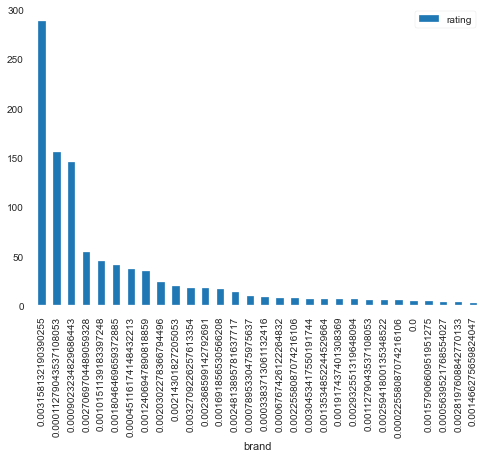

In [33]:
#посмотрим на распределение рейтингов по brandам
brands = pd.DataFrame(train.groupby('brand')['rating'].count())
active_brands= brands.head(30).sort_values('rating', ascending=False)
active_brands.head(30).plot(kind = "bar")

<AxesSubplot:xlabel='main_cat'>

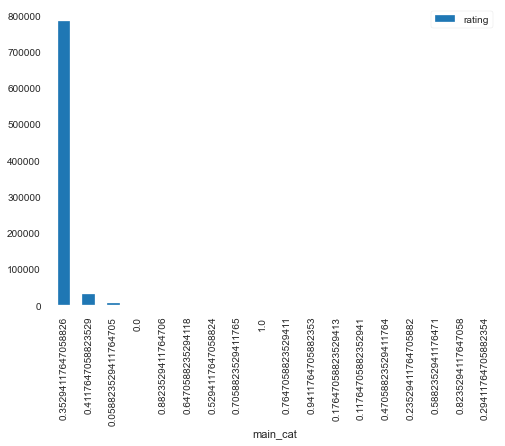

In [34]:
#посмотрим на распределение рейтингов по категориям
brands = pd.DataFrame(train.groupby('main_cat')['rating'].count())
active_brands= brands.head(30).sort_values('rating', ascending=False)
active_brands.head(30).plot(kind = "bar")

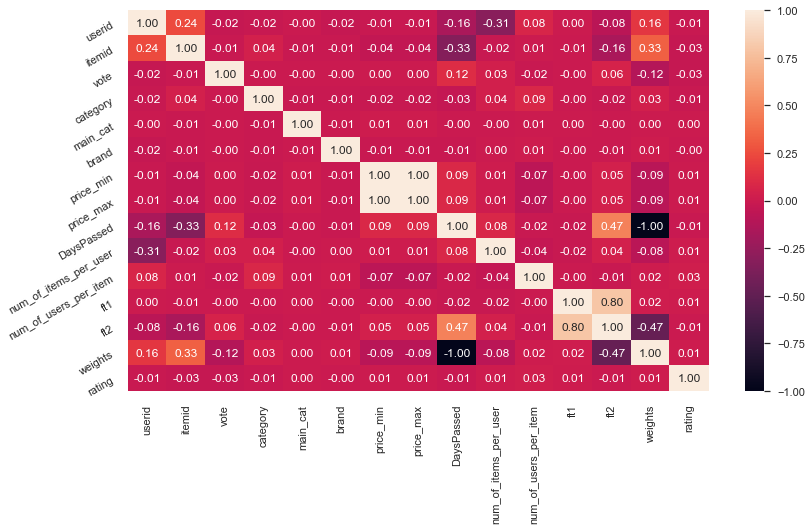

In [35]:
#Посмотрим на корреляции в трейне
corr=train.corr()

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

Графики показывают, что для брендов есть топ 3 явно выраженных лидера. Аналогично, для main_cat есть категория grossery, значительно превосходящая по числу остальные категории

Несмотря на генерацию новых фичей, их корреляции достаточно слабы, поэтому для дальнейшего обучения ограничимся только несколькими из них для демонстрации работы алгоритма с матрицей item-features.

In [36]:
#Функции для создания списка id для items и users и генерации матриц признаков
def generate_int_id(dataframe, id_col_name):
    new_dataframe=dataframe.assign(
        int_id_col_name=np.arange(len(dataframe))
        ).reset_index(drop=True)
    return new_dataframe.rename(columns={'int_id_col_name': id_col_name})


def create_features(dataframe, features_name, id_col_name):
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features

def generate_feature_list(dataframe, features_name):
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features

In [37]:
#Формируем списки Id для пользователей и продуктов
train = generate_int_id(train, 'userid_num')
train = generate_int_id(train, 'itemid_num')

list_item_features =['DaysPassed','num_of_items_per_user','ft1',
                     'ft2', 'num_of_users_per_item', 'price_max', 'vote'] 

# создание признаков для передачи в алгоритм
train['item_features'] = create_features(train, list_item_features, 'itemid_num')

# генерация списка признаков
item_feature_list = generate_feature_list(train,list_item_features)

# Построение матрицы через датасет lightfm

dataset = Dataset()
dataset.fit(
    set(train['userid_num']), 
    set(train['itemid_num']),
    user_features=None, 
    item_features=item_feature_list)
 
item_features = dataset.build_item_features(train['item_features'])
#user_features = dataset.build_user_features(df['user_features'])

In [38]:
# Подготавливаем данные: разбиваем выборку на обучение и тест и генерируем матрицы
train_data, test_data = train_test_split(train,random_state=12, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
sample_weights = sparse.coo_matrix((train_data['weights'], (train_data['userid'],
                                  train_data['itemid'])))

In [39]:
#Обучаем модель
model = LightFM (learning_rate=0.1, 
                loss='logistic',
                learning_schedule= 'adagrad',
                no_components=120)
model = model.fit(ratings_coo, 
                  sample_weight = sample_weights, 
                  item_features = item_features,
                  epochs=20,  
                  num_threads=4)

model.item_biases *= 1.0
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values,
                      item_features = item_features)

roc_auc_score(test_data.rating, preds)

0.6657767589299763

In [40]:
#Обучаем модель без признаков
model = LightFM (learning_rate=0.1, 
                loss='logistic',
                learning_schedule= 'adagrad',
                no_components=120)
model = model.fit(ratings_coo, 
                  sample_weight = sample_weights, 
                  epochs=20,  
                  num_threads=4)

model.item_biases *= 1.0
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values)

roc_auc_score(test_data.rating, preds)

0.7301208206000465

In [41]:
# %%script false

import itertools

def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(30, 200),
            "loss": np.random.choice(["logistic", "bpr","warp"]),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "learning_rate": np.random.exponential(0.05),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)
        preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values)
        score = roc_auc_score(test_data.rating,preds)
        
        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

(score, hyperparams, model) = max(random_search(ratings_coo, test_data, num_samples=50), key=lambda x: x[0])
print(f"Best score {score} at {hyperparams}")

Best score 0.7263288445340915 at {'no_components': 154, 'loss': 'logistic', 'learning_schedule': 'adagrad', 'learning_rate': 0.0912033858761851, 'num_epochs': 23}


In [42]:
#Model fitting
model = LightFM (learning_rate=0.06302151135470872, 
                loss='logistic',
                learning_schedule= 'adagrad',
                no_components=170)
model = model.fit(ratings_coo, 
                  sample_weight = sample_weights, 
                  epochs=32,  
                  num_threads=4)

model.item_biases *= 1.0
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values)

roc_auc_score(test_data.rating, preds)

0.7269257316966953

In [43]:
print("Train recall: %.2f" % recall_at_k(model, ratings_coo, k=5).mean())
print("Train precision: %.2f" % precision_at_k(model, ratings_coo, k=5).mean())

Train recall: 0.11
Train precision: 0.09


In [44]:
test = data_preparation(test)
test = test[['userid', 'itemid','vote', 'category', 'main_cat', 'brand', 'price_max',
               'DaysPassed', 'num_of_items_per_user', 'num_of_users_per_item',
               'ft1','ft2','weights']]
test.to_csv('test_working.csv')
test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,userid,itemid,vote,category,main_cat,brand,price_max,DaysPassed,num_of_items_per_user,num_of_users_per_item,ft1,ft2,weights
0,68877,7506,0.000000,0.177656,0.352941,0.665110,0.039079,0.122610,0.022059,0.002111,0.857143,0.205965,0.877390
1,50442,15530,0.000774,0.452381,0.352941,0.014248,0.005445,0.260986,0.014706,0.001055,1.000000,0.391464,0.739014
2,64349,15049,0.000000,0.038462,0.352941,0.355843,0.055006,0.206642,0.014706,0.001055,0.285714,0.055798,0.793358
3,26206,11957,0.000000,0.051282,0.411765,0.630148,0.010561,0.244549,0.007353,0.004222,1.000000,0.374322,0.755451
4,59366,12173,0.001161,0.174908,0.352941,0.164033,0.030981,0.299564,0.051471,0.040633,0.142857,0.000000,0.700436


In [45]:
test = generate_int_id(test, 'userid_num')
test = generate_int_id(test, 'itemid_num')

test['item_features'] = create_features(test, list_item_features, 'itemid_num')

item_feature_list_test = generate_feature_list(test,list_item_features)

dataset_test = Dataset()
dataset_test.fit(
    set(test['userid_num']), 
    set(test['itemid_num']),
    user_features=None, 
    item_features=item_feature_list_test)

item_features_test = dataset_test.build_item_features(test['item_features'])

In [46]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

preds.min(), preds.max()

(-36.17748260498047, 31.355161666870117)

In [47]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [48]:
submission['rating']= normalized_preds

In [49]:
submission.to_csv('submission_comp.csv', index=False)

submission.head()

,Id,rating
0,0,0.560107
1,1,0.552696
2,2,0.540207
3,3,0.536010
4,4,0.565386


In [50]:
item_biases, item_embeddings = model.get_item_representations()

In [51]:
#Сохранение векторных представлений для модели
import pickle
with open('item_embeddings_lfm_comp.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

# 5 Выводы
1 Построена базовая модель.

2 Подобраны параметры модели с целью уменьшить RocAuc, добавлена регуляризация и признаки товаров.

3 Добавлены признаки товаров. Добавление признаков в модель приводит к ухудшению RocAuc.

4 Даны рекомендации пользователю на основе эмбеддингов понравившихся товаров.